In [1]:
import tensorflow.python.client
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4010103964592450438
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10081009664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14875442101908233928
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [31]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2

# GPU로학습
physical_devices = tf.config.list_physical_devices('GPU')

# 데이터 증강 및 전처리
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# 학습데이터셋
train_dataset = train_datagen.flow_from_directory(
    'E:/종설/Training/ex',
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
)

# 검증데이터셋
val_dataset = val_datagen.flow_from_directory(
    'E:/종설/Validation/ex',
    target_size=(256, 256),
    batch_size=32,
)

# TensorFlow_Hub_v2 불러오기
module_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
feature_extractor_layer = hub.KerasLayer(module_url, trainable=False)
input_shape = (256,256,3)

#L2정규화적용, dropout도 적용
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.01))
])

# 마지막층 빼고 동결
for layer in model.layers[:-1]:
    layer.trainable = False

# 컴파일 학습률 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

num_epochs = 50
best_val_acc = 0.0

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
)

# 모델저장
best_val_acc = max(history.history['val_accuracy'])
model.save('my_model_ex.h5')


PermissionError: [Errno 13] Permission denied: 'E:/종설/Training/label_ex'

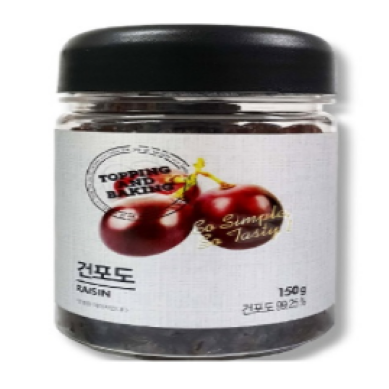

결과순위 1: 35102_삼양사)건포도150G (0.69)
결과순위 2: 10102_농심신라면컵65G (0.08)
결과순위 3: 10101_농심오징어짬뽕컵67G (0.05)


In [26]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('my_model_ex.h5', custom_objects={'KerasLayer':hub.KerasLayer})


# Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex\gunpodo.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (256, 256))
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Predict the label of the image
preds = model.predict(img)
class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())

# Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

i=1;
# Print out the top three predicted labels and probabilities
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i=i+1

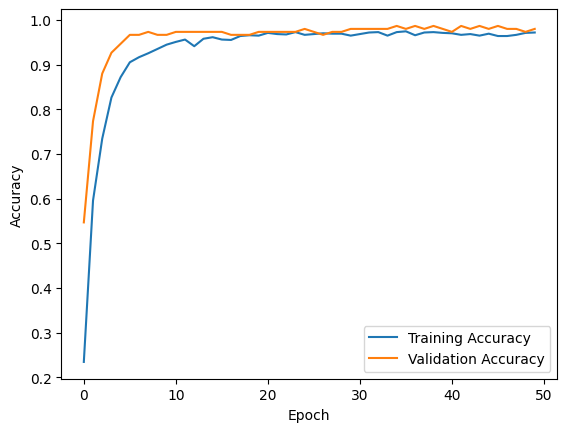

In [43]:
import matplotlib.pyplot as plt

# Get the accuracy values from history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy values
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2

# Train with GPU
physical_devices = tf.config.list_physical_devices('GPU')

# Step 1: Read and parse XML files for training data
train_data_path = 'E:/종설/Training/ex'
train_labels = {}  # Dictionary to store image filenames and their labels

for class_name in os.listdir(train_data_path):
    class_path = os.path.join(train_data_path, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if file_name.endswith('.xml'):
                xml_path = os.path.join(class_path, file_name)
                tree = ET.parse(xml_path)
                root = tree.getroot()
                image_file_name = os.path.splitext(file_name)[0]  # Get image filename without '.xml' extension
                label = root.find('label').text
                train_labels[image_file_name] = label
                
# If XML files are located in a different directory
other_directory_train = 'E:/종설/Training/label_ex'  # Specify the path to the other directory here

for file_name in os.listdir(other_directory_train):
    if file_name.endswith('.xml'):
        xml_path = os.path.join(other_directory, file_name)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        image_file_name = os.path.splitext(file_name)[0]  # Get image filename without '.xml' extension
        label = root.find('label').text
        train_labels[image_file_name] = label

# Step 2: Create a list of class names for validation data
val_data_path = 'E:/종설/Validation/ex'
val_labels = {}  # Dictionary to store image filenames and their labels

for class_name in os.listdir(val_data_path):
    class_path = os.path.join(val_data_path, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if file_name.endswith('.xml'):
                xml_path = os.path.join(class_path, file_name)
                tree = ET.parse(xml_path)
                root = tree.getroot()
                image_file_name = os.path.splitext(file_name)[0]  # Get image filename without '.xml' extension
                label = root.find('label').text
                val_labels[image_file_name] = label
                
# If XML files are located in a different directory
other_directory_vali = 'E:/종설/Validation/label_ex'  # Specify the path to the other directory here

for file_name in os.listdir(other_directory_train):
    if file_name.endswith('.xml'):
        xml_path = os.path.join(other_directory, file_name)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        image_file_name = os.path.splitext(file_name)[0]  # Get image filename without '.xml' extension
        label = root.find('label').text
        train_labels[image_file_name] = label

# training dataset
train_dataset = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    classes=list(train_labels.values())  # Convert dictionary values to a list
)

# validation dataset
val_dataset = val_datagen.flow_from_directory(
    val_data_path,
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    classes=list(val_labels.values())  # Convert dictionary values to a list
)

# TensorFlow_Hub_v2 불러오기
module_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
feature_extractor_layer = hub.KerasLayer(module_url, trainable=False)
input_shape = (256,256,3)

#L2정규화적용, dropout도 적용
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.01))
])

# 마지막층 빼고 동결
for layer in model.layers[:-1]:
    layer.trainable = False

# 컴파일 학습률 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

num_epochs = 50
best_val_acc = 0.0

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
)

# 모델저장
best_val_acc = max(history.history['val_accuracy'])
model.save('my_model_ex.h5')


Found 1140 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Epoch 1/50
29/36 [=======================>......] - ETA: 14s - loss: 2.3656 - accuracy: 0.2118

KeyboardInterrupt: 

In [29]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd


def read_xml_file(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)
    return labels

def read_xml_and_add_labels(image_path, label_directory):
    image_name = os.path.basename(image_path)
    # Extract the class name from the image file path
    class_name = os.path.dirname(image_path).split(os.path.sep)[-1]
    xml_file_path = os.path.join(label_directory, class_name, image_name[:-4] + '.xml')
    labels = read_xml_file(xml_file_path)
    return labels

# Modify train_datagen
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# Set up the training dataset
train_directory = 'E:/종설/Training/ex'
train_label_directory = 'E:/종설/Training/label_ex'
train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=42,  # add a seed for reproducibility
    follow_links=True,  # follow symbolic links if any
    classes=None,  # set to None to use default class mode
)

# Retrieve labels for training images
train_labels = []
for i, image_path in enumerate(train_dataset.filepaths):
    labels = read_xml_and_add_labels(image_path, train_label_directory)
    train_labels.append(labels)

# Convert the list of labels to a numpy array
train_labels = np.array(train_labels)

# Modify val_datagen
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# Set up the validation dataset
val_directory = 'E:/종설/Validation/ex'
val_label_directory = 'E:/종설/Validation/label_ex'
val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=32,
    shuffle=False,
    classes=None,  # set to None to use default class mode
)

# Retrieve labels for validation images
val_labels = []
for i, image_path in enumerate(val_dataset.filepaths):
    labels = read_xml_and_add_labels(image_path, val_label_directory)
    val_labels.append(labels)

# Convert the list of labels to a numpy array
val_labels = np.array(val_labels)

# Access the image paths and labels from the data generators
train_image_paths = train_dataset.filepaths
val_image_paths = val_dataset.filepaths

# The train_labels and val_labels will be numpy arrays of labels for each image in the batch.
# You can use these labels for training and validation accordingly.


Found 1140 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


C:\Users\sj990\AppData\Local\Temp\ipykernel_9544\3737239443.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)
C:\Users\sj990\AppData\Local\Temp\ipykernel_9544\3737239443.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_labels = np.array(val_labels)


In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET

# GPU로학습
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Define a function to read labels from an XML file
def read_xml_file(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)
    return labels

# Define a function to read XML files and add labels to the image paths
def read_xml_and_add_labels(image_path, label_directory):
    image_name = os.path.basename(image_path)
    # Extract the class name from the image file path
    class_name = os.path.dirname(image_path).split(os.path.sep)[-1]
    xml_file_path = os.path.join(label_directory, class_name, image_name[:-4] + '.xml')
    labels = read_xml_file(xml_file_path)
    return labels

# Modify train_datagen
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# Set up the training dataset
train_directory = 'E:/종설/Training/ex'
train_label_directory = 'E:/종설/Training/label_ex'
train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=42,  # add a seed for reproducibility
    follow_links=True,  # follow symbolic links if any
    classes=None,  # set to None to use default class mode
)

# 훈련라벨
train_labels = []
for i, image_path in enumerate(train_dataset.filepaths):
    labels = read_xml_and_add_labels(image_path, train_label_directory)
    train_labels.append(labels)


train_labels = np.array(train_labels)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# 검증데이터
val_directory = 'E:/종설/Validation/ex'
val_label_directory = 'E:/종설/Validation/label_ex'
val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=32,
    shuffle=False,
    classes=None,  # set to None to use default class mode
)

# 검증라벨
val_labels = []
for i, image_path in enumerate(val_dataset.filepaths):
    labels = read_xml_and_add_labels(image_path, val_label_directory)
    val_labels.append(labels)

val_labels = np.array(val_labels)

# TensorFlow_Hub_v2 불러오기
module_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
feature_extractor_layer = hub.KerasLayer(module_url, trainable=False)
input_shape = (256,256,3)

#L2정규화적용, dropout도 적용
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

# 마지막층 빼고 동결
for layer in model.layers[:-1]:
    layer.trainable = False

# 컴파일 학습률 0.005
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.004),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

num_epochs = 50
best_val_acc = 0.0

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
)

# 모델저장
best_val_acc = max(history.history['val_accuracy'])
model.save('my_model_ex_label_v8.h5')

Physical devices cannot be modified after being initialized
Found 1140 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


C:\Users\sj990\AppData\Local\Temp\ipykernel_16792\1033456355.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)
C:\Users\sj990\AppData\Local\Temp\ipykernel_16792\1033456355.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_labels = np.array(val_labels)


Epoch 1/50
36/36 [==============================] - 84s 2s/step - loss: 1.7362 - accuracy: 0.4474 - val_loss: 1.0458 - val_accuracy: 0.8533
Epoch 2/50
36/36 [==============================] - 84s 2s/step - loss: 0.8861 - accuracy: 0.8272 - val_loss: 0.6356 - val_accuracy: 0.9467
Epoch 3/50
36/36 [==============================] - 83s 2s/step - loss: 0.6681 - accuracy: 0.8886 - val_loss: 0.5017 - val_accuracy: 0.9667
Epoch 4/50
 9/36 [======>.......................] - ETA: 56s - loss: 0.5934 - accuracy: 0.8750

KeyboardInterrupt: 

In [17]:
if len(train_labels) > 0:
    print("Labels were used during training.")
else:
    print("Labels were not used during training.")

Labels were used during training.


In [18]:
import matplotlib.pyplot as plt

# Get the accuracy values from history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy values
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [78]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('my_model_ex_label_v4.h5', custom_objects={'KerasLayer':hub.KerasLayer})


# Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex\10102_농심신라면컵65G\shin.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Predict the label of the image
preds = model.predict(img)
class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())

# Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

i=1;
# Print out the top three predicted labels and probabilities
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i=i+1

TypeError: imshow() missing 1 required positional argument: 'X'

In [103]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET

# Load the model
model = tf.keras.models.load_model('my_model_ex_label_v5.h5', custom_objects={'KerasLayer':hub.KerasLayer})

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # you can specify other data augmentation techniques or preprocessing steps here
test_generator = test_datagen.flow_from_directory(
        r'C:\Users\sj990\Desktop\ex', 
        target_size=(256, 256), 
        batch_size=1, 
        class_mode='categorical', 
        shuffle=False) 

scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100)) 

Found 30 images belonging to 10 classes.
30/30 [==============================] - 2s 14ms/step - loss: 0.4048 - accuracy: 0.8667
Accuracy: 86.67%


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET

# GPU로학습
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            pass
        
tf.config.set_visible_devices(gpus[0], 'GPU')

# 라벨
def read_xml_file(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)
    return labels

def read_xml_and_add_labels(image_path, label_directory):
    image_name = os.path.basename(image_path)
    class_name = os.path.dirname(image_path).split(os.path.sep)[-1]
    xml_file_path = os.path.join(label_directory, class_name, image_name[:-4] + '.xml')
    labels = read_xml_file(xml_file_path)
    return labels

# 데이터증강기법
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# 훈련 데이터셋
train_directory = 'E:/종설/Training/ex'
train_label_directory = 'E:/종설/Training/label_ex'
train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=42,  # add a seed for reproducibility
    follow_links=True,  # follow symbolic links if any
    classes=None,  # set to None to use default class mode
)

# 훈련라벨
train_labels = []
for i, image_path in enumerate(train_dataset.filepaths):
    labels = read_xml_and_add_labels(image_path, train_label_directory)
    train_labels.append(labels)


train_labels = np.array(train_labels)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# 검증데이터
val_directory = 'E:/종설/Validation/ex'
val_label_directory = 'E:/종설/Validation/label_ex'
val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=32,
    shuffle=False,
    classes=None,  # set to None to use default class mode
)

# 검증라벨
val_labels = []
for i, image_path in enumerate(val_dataset.filepaths):
    labels = read_xml_and_add_labels(image_path, val_label_directory)
    val_labels.append(labels)

val_labels = np.array(val_labels)

# EfficientNet-B0모델 불러오기
pretrained_model = hub.KerasLayer("C:/Users/sj990/MachineLearning/efficientnet_b0_classification_1")

# 층 추가
model = Sequential()
model.add(pretrained_model)
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

# 동결
for layer in model.layers[:-1]:
    layer.trainable = False


Found 1140 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


C:\Users\sj990\AppData\Local\Temp\ipykernel_18292\3170225034.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)
C:\Users\sj990\AppData\Local\Temp\ipykernel_18292\3170225034.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_labels = np.array(val_labels)


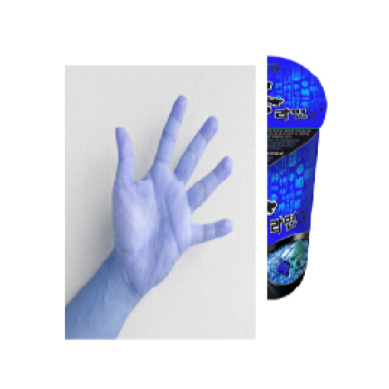

결과순위 1: 25222_대만)망고케익184g (0.54)
결과순위 2: 10101_농심오징어짬뽕컵67G (0.22)
결과순위 3: 10104_오뚜기)컵누들김치쌀국수34.8G (0.07)


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('my_model_ex_label_v13.h5', custom_objects={'KerasLayer':hub.KerasLayer})


# Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex\image.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Predict the label of the image
preds = model.predict(img)
class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())

# Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

i=1;
# Print out the top three predicted labels and probabilities
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i=i+1

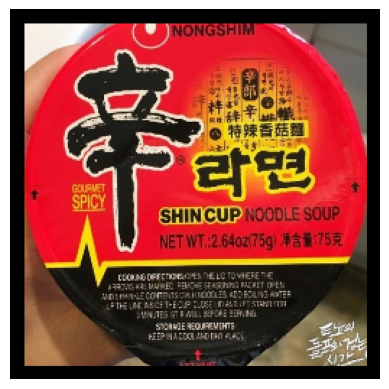

결과순위 1: 10102_농심신라면컵65G (0.37)
결과순위 2: 10101_농심오징어짬뽕컵67G (0.35)
결과순위 3: 10111_오뚜기컵누들매콤37.8G (0.11)


In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('my_model_ex_label_v40.h5', custom_objects={'KerasLayer':hub.KerasLayer})

# Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex\shin.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

# Define a mask to apply to the edges of the image
h, w = img.shape[:2]
mask = np.zeros((h, w), dtype=np.uint8)
cv2.rectangle(mask, (10, 10), (w-10, h-10), (255, 255, 255), -1)
masked_img = cv2.bitwise_and(img, img, mask=mask)

# Preprocess the masked image
masked_img = masked_img.astype('float32') / 255.0
masked_img = np.expand_dims(masked_img, axis=0)

# Show the masked image
plt.imshow(masked_img[0])
plt.axis('off')
plt.show()

# Predict the label of the image
preds = model.predict(masked_img)
class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())

# Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

i=1;
# Print out the top three predicted labels and probabilities
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i=i+1


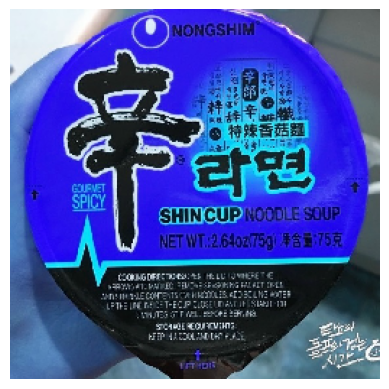

결과순위 1: 10102_농심신라면컵65G (0.42)
결과순위 2: 10101_농심오징어짬뽕컵67G (0.29)
결과순위 3: 10111_오뚜기컵누들매콤37.8G (0.11)


In [55]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('my_model_ex_label_v40.h5', custom_objects={'KerasLayer':hub.KerasLayer})


# Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex\shin.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Predict the label of the image
preds = model.predict(img)
class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())

# Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

i=1;
# Print out the top three predicted labels and probabilities
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i=i+1

In [45]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('my_model_ex_label_v40.h5', custom_objects={'KerasLayer':hub.KerasLayer})

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_dir = r'C:\Users\sj990\Desktop\ex'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

preds = model.predict_generator(test_generator, verbose=1)
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

num_images = len(preds)
for i in range(num_images):
    img_path = test_generator.filepaths[i]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    top_preds_idx = preds[i].argsort()[::-1][:3]
    top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
    top_preds_probs = preds[i][top_preds_idx]

    print(f"\n{i+1}. Image file: {img_path}")
    for label, prob in zip(top_preds_labels, top_preds_probs):
        print(f"    {label} ({prob:.2f})")

correct_predictions = 0
for i in range(num_images):
    if np.argmax(preds[i]) == test_generator.labels[i]:
        correct_predictions += 1
accuracy = correct_predictions / num_images
print("\nOverall accuracy: %.2f%%" % (accuracy * 100))


Found 61 images belonging to 10 classes.
61/61 [==============================] - 1s 14ms/step

1. Image file: C:\Users\sj990\Desktop\ex\10101_농심오징어짬뽕컵67G\123.jpg
    10101_농심오징어짬뽕컵67G (0.98)
    10102_농심신라면컵65G (0.01)
    10111_오뚜기컵누들매콤37.8G (0.00)

2. Image file: C:\Users\sj990\Desktop\ex\10101_농심오징어짬뽕컵67G\VC.jpg
    10101_농심오징어짬뽕컵67G (0.99)
    10102_농심신라면컵65G (0.00)
    10104_오뚜기)컵누들김치쌀국수34.8G (0.00)

3. Image file: C:\Users\sj990\Desktop\ex\10101_농심오징어짬뽕컵67G\VCV.jpg
    10101_농심오징어짬뽕컵67G (1.00)
    10111_오뚜기컵누들매콤37.8G (0.00)
    10103_오뚜기참깨라면(컵) (0.00)

4. Image file: C:\Users\sj990\Desktop\ex\10101_농심오징어짬뽕컵67G\VCVC.jpg
    10101_농심오징어짬뽕컵67G (0.83)
    10102_농심신라면컵65G (0.08)
    10104_오뚜기)컵누들김치쌀국수34.8G (0.06)

5. Image file: C:\Users\sj990\Desktop\ex\10101_농심오징어짬뽕컵67G\cxcx.jpg
    10101_농심오징어짬뽕컵67G (0.99)
    10102_농심신라면컵65G (0.01)
    10268_아넬라사과디저트_2입 (0.00)

6. Image file: C:\Users\sj990\Desktop\ex\10101_농심오징어짬뽕컵67G\sdaasd.jpg
    10101_농심오징어짬뽕컵67G (0.91)
    10102_농심신라면컵65G (0


59. Image file: C:\Users\sj990\Desktop\ex\35102_삼양사)건포도150G\vcbvcbvc.jpg
    35102_삼양사)건포도150G (1.00)
    10111_오뚜기컵누들매콤37.8G (0.00)
    10102_농심신라면컵65G (0.00)

60. Image file: C:\Users\sj990\Desktop\ex\35102_삼양사)건포도150G\vcbvcbvcbvcxsdwq.jpg
    35102_삼양사)건포도150G (1.00)
    10111_오뚜기컵누들매콤37.8G (0.00)
    10102_농심신라면컵65G (0.00)

61. Image file: C:\Users\sj990\Desktop\ex\35102_삼양사)건포도150G\vcxvx.jpg
    35102_삼양사)건포도150G (1.00)
    10102_농심신라면컵65G (0.00)
    10111_오뚜기컵누들매콤37.8G (0.00)

Overall accuracy: 93.44%


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 정규화
x_train = x_train / 255.0
x_test = x_test / 255.0

# resnet50모델 불러오기
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# 동결
for layer in base_model.layers:
    layer.trainable = False

# 추가 층추가
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

# 모델정의
model = Model(inputs=base_model.input, outputs=output)

# C컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# 모델성능측정
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

94683136/94668760 [==============================] - 11s 0us/step
Epoch 1/10
1260/1563 [=======================>......] - ETA: 4s - loss: 1.8603 - accuracy: 0.3499

In [ ]:
# Step 1: Save class labels to text file
class_labels = []
for filename in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, filename)):
        class_labels.append(filename)

with open(class_labels_file, 'w') as file:
    for label in class_labels:
        file.write(label + '\n')

In [5]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

# Directory and file paths
directory = 'E:/종설/Training/[원천]미분류'
class_labels_file = 'class_labels.txt'
model_file = 'my_model_ex_label_v51.h5'

# Step 2: Load the model
model = tf.keras.models.load_model(model_file, custom_objects={'KerasLayer': hub.KerasLayer})

# Step 3: Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex\KakaoTalk_20230421_152615727.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

# Step 4: Predict the label of the image
preds = model.predict(img)

# Step 5: Load class labels from the text file
class_labels = []
with open(class_labels_file, 'r') as file:
    for line in file:
        class_labels.append(line.strip())

# Step 6: Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

# Step 7: Print out the top three predicted labels and probabilities
i = 1
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i += 1

결과순위 1: 45432_한국라이스텍)찹쌀 (0.93)
결과순위 2: 35447_한국라이스텍)쌀찰보리 (0.06)
결과순위 3: 45089_소시에뜨)사프인스턴트이스트레드32G (0.01)
